In [2]:
%matplotlib inline

In [3]:
#dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from citipy import citipy
import requests
from config import weather_api_key
import time
from datetime import datetime
from scipy.stats import linregress

## Gathering Data

In [ ]:
#make random latlong pairs
np.random.seed(2022)
lats = np.random.uniform(-90, 90, size = 1500)
longs = np.random.uniform(-180, 180, size = 1500)

lat_longs = zip(lats, longs)

coordinates = list(lat_longs)

In [ ]:
#make list of cities from those latlongs
cities = []

for coordinate in coordinates:
    #identify the nearest city
    city = citipy.nearest_city(coordinate[0], coordinate[1]).city_name

    #check to see if we have that city and if not, add it to the list
    if city not in cities:
        cities.append(city)

In [ ]:
# list to hold weather data
city_data = []
url = "https://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=" + weather_api_key

# print beggining of logging
print("Beginning Data Retrieval     ")
print("-----------------------------")

#set up counters
record_count = 1
set_count = 1


for i, city in enumerate(cities):

    #Group cities in sets of 50 to avoid timing out
    if (i % 50 == 0) and (i >= 50):
        set_count +=1
        record_count = 1
        time.sleep(60)

    #log the url, record, and set numbers and the city
    print(f"Processing Record {record_count} of Set {set_count} | {city}")
    
    #build city url note: replace is taking spaces in names and replacing them with + to not just get data for first part of name
    city_url = url + "&q=" + city

    #run an api request on city
    try:
        #get the json data
        city_weather = requests.get(city_url).json()

        #parse the data
        city_lat = city_weather["coord"]["lat"]
        city_long = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_winds = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]

        #convert date
        city_date = datetime.utcfromtimestamp(city_weather["dt"]).strftime("%Y-%m-%d %H:%M:%S")

        #add city data to the list
        city_data.append({"City": city.title(),
                        "Lat": city_lat,
                        "Long": city_long,
                        "Max Temp": city_max_temp,
                        "Humidity": city_humidity,
                        "Cloudiness": city_clouds,
                        "Wind Speed": city_winds,
                        "Country": city_country,
                        "Date": city_date})
    
    #skip the city if it isn't found
    except:
        print(f"City not found. Skipping...")
        pass 

    #add 1 to record count
    record_count += 1

#note that data loading is complete
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

In [ ]:
#build data frame from the city data list
city_data_df = pd.DataFrame(city_data)

#reorder
column_order =  ["City", "Country", "Date", "Lat", "Long", "Max Temp", "Humidity", "Cloudiness", "Wind Speed"]
city_data_df = city_data_df[column_order]


In [ ]:
#save the city and weather data to a csv

output_data_file = "weather_data/cities.csv"
city_data_df.to_csv(output_data_file, index_label="City_ID")

In [4]:
#import city and weather data to avoid API call the next day

city_data_df = pd.read_csv("weather_data/cities.csv")

## Scatter Plots

In [11]:
# extract relevant columns for plotting

lats = city_data_df["Lat"]
max_temps = city_data_df["Max Temp"]
humidity = city_data_df["Humidity"]
cloudiness = city_data_df["Cloudiness"]
wind_speed = city_data_df["Wind Speed"]

today = time.strftime("%x")

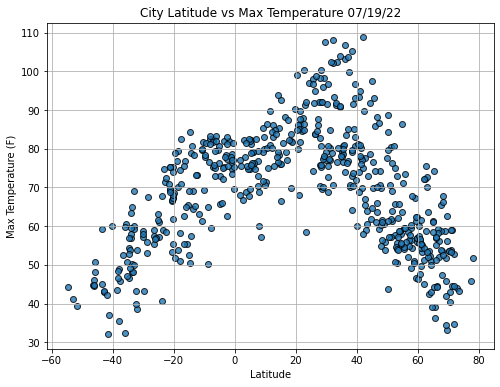

In [58]:
#set up max temp figure
fig, ax1 = plt.subplots(figsize = (8,6))
fig.set_facecolor("w")

#define scatter plot
ax1.scatter(lats, max_temps,
        edgecolor = "k",
        linewidths = 1,
        marker = "o",
        alpha = 0.8,
        label = "Cities")

#set labels and turn grid on
ax1.set(xlabel = "Latitude",
        ylabel = "Max Temperature (F)",
        title = f"City Latitude vs Max Temperature " + today)
plt.grid(True)


#save and show
#plt.savefig("weather_data/Fig1.png")

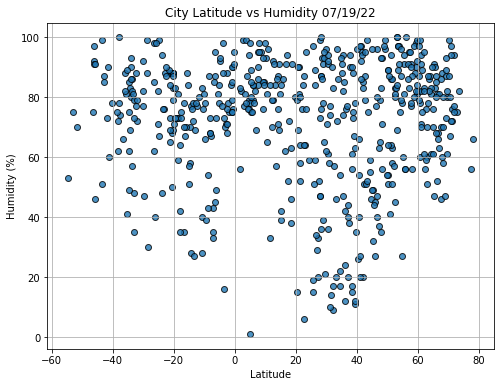

In [49]:
#set up humidity figure
fig, ax2 = plt.subplots(figsize = (8,6))
fig.set_facecolor("w")

#define scatter plot
ax2.scatter(lats, humidity,
        edgecolor = "k",
        linewidths = 1,
        marker = "o",
        alpha = 0.8,
        label = "Cities")

#set labels and turn grid on
ax2.set(xlabel = "Latitude",
        ylabel = "Humidity (%)",
        title = f"City Latitude vs Humidity " + today)
plt.grid(True)


#save and show
#plt.savefig("weather_data/Fig2.png")

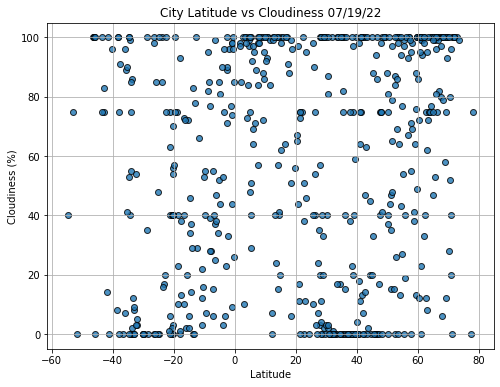

In [50]:
#set up cloudiness figure
fig, ax3 = plt.subplots(figsize = (8,6))
fig.set_facecolor("w")

#define scatter plot
ax3.scatter(lats, cloudiness,
        edgecolor = "k",
        linewidths = 1,
        marker = "o",
        alpha = 0.8,
        label = "Cities")

#set labels and turn grid on
ax3.set(xlabel = "Latitude",
        ylabel = "Cloudiness (%)",
        title = f"City Latitude vs Cloudiness " + today)
plt.grid(True)


#save and show
#plt.savefig("weather_data/Fig3.png")


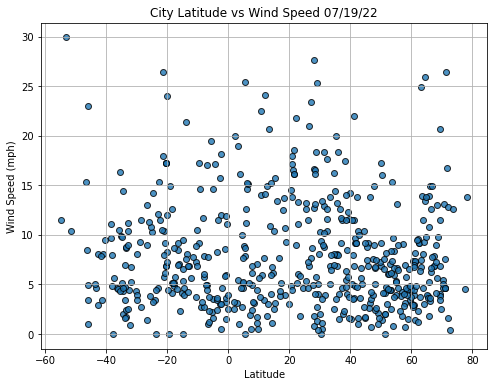

In [51]:
#set up wind speed figure
fig, ax4 = plt.subplots(figsize = (8,6))
fig.set_facecolor("w")

#define scatter plot
ax4.scatter(lats, wind_speed,
        edgecolor = "k",
        linewidths = 1,
        marker = "o",
        alpha = 0.8,
        label = "Cities")

#set labels and turn grid on
ax4.set(xlabel = "Latitude",
        ylabel = "Wind Speed (mph)",
        title = f"City Latitude vs Wind Speed " + today)
plt.grid(True)


#save and show
#plt.savefig("weather_data/Fig4.png")

## Linear Regressions

In [39]:
#build function to plot the linear regression for us

def plot_linear_regression(x_vals, y_vals, title, y_label, text_coordinates):

    #run regression on hemisphere weather data
    (slope, intercept, rval, pval, stderr) = linregress(x_vals, y_vals)

    #calculate regression line
    regress_values = x_vals*slope + intercept

    #build equation of the line for posting
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept,2))

    #build scatter plot and regression line
    plt.scatter(x_vals,y_vals)
    plt.plot(x_vals,regress_values, "r")

    #annotate and add labels
    plt.annotate(line_eq, text_coordinates, fontsize = 15, color = "r")
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel(y_label)

    #show plot
    plt.show()

    #print rvalue
    print(f"The Rvalue is {rval:.3f}")

In [18]:
#build databases by hemisphere

northern_hemi_df = city_data_df[city_data_df["Lat"] >= 0]
southern_hemi_df = city_data_df[city_data_df["Lat"] < 0]

northern_hemi_df.head(10)

,City_ID,City,Country,Date,Lat,Long,Max Temp,Humidity,Cloudiness,Wind Speed
4,4,Northport,US,2022-07-18 21:51:02,33.2290,-87.5772,91.22,46,0,6.91
6,6,Srednekolymsk,RU,2022-07-18 21:51:03,67.4500,153.6833,65.52,46,97,7.92
7,7,Katsuura,JP,2022-07-18 21:51:04,35.1333,140.3000,79.21,88,100,19.98
8,8,Chokurdakh,RU,2022-07-18 21:51:04,70.6333,147.9167,43.07,67,80,13.11
9,9,Torbay,CA,2022-07-18 21:50:32,47.6666,-52.7314,74.17,65,75,14.97
10,10,Boksitogorsk,RU,2022-07-18 21:51:05,59.4740,33.8485,46.60,98,13,3.44
11,11,Kirillov,RU,2022-07-18 21:51:06,59.8630,38.3813,55.80,81,100,4.45
12,12,Yellowknife,CA,2022-07-18 21:51:06,62.4560,-114.3525,72.12,56,40,9.22
16,16,Taoudenni,ML,2022-07-18 21:51:08,22.6783,-3.9836,100.26,6,0,6.04
17,17,Tasiilaq,GL,2022-07-18 21:51:09,65.6145,-37.6368,39.16,83,53,1.81


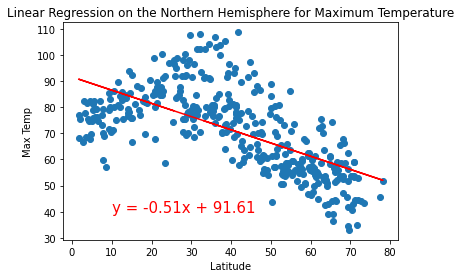

The Rvalue is -0.650


In [40]:
#call the function on max temp [northern hemi]

plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Max Temp"],
                        "Linear Regression on the Northern Hemisphere for Maximum Temperature",
                        "Max Temp",
                        (10,40))

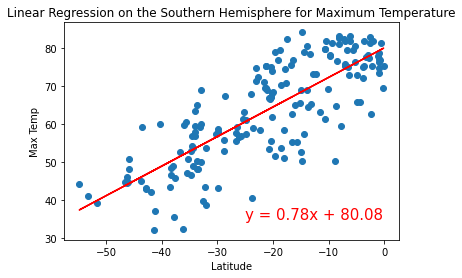

The Rvalue is 0.798


In [41]:
#call the function on max temp [southern hemi]

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Max Temp"],
                        "Linear Regression on the Southern Hemisphere for Maximum Temperature",
                        "Max Temp",
                        (-25,35))

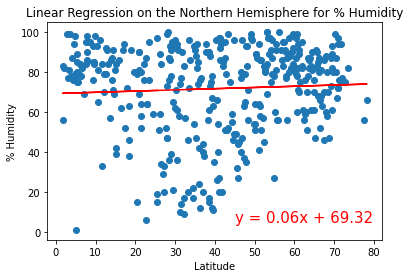

The Rvalue is 0.054


In [42]:
#call the function on humidity [northern hemi]

plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Humidity"],
                        "Linear Regression on the Northern Hemisphere for % Humidity",
                        "% Humidity",
                        (45,5))

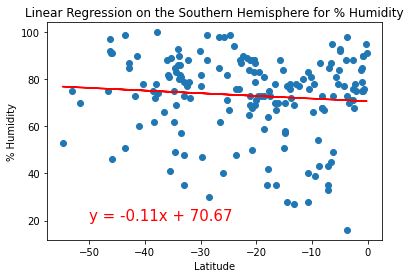

The Rvalue is -0.089


In [43]:
#call the function on humidity [southern hemi]

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"],
                        "Linear Regression on the Southern Hemisphere for % Humidity",
                        "% Humidity",
                        (-50,20))

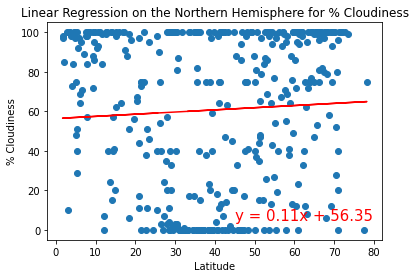

The Rvalue is 0.057


In [44]:
#call the function on cloudiness [northern hemi]

plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Cloudiness"],
                        "Linear Regression on the Northern Hemisphere for % Cloudiness",
                        "% Cloudiness",
                        (45,5))

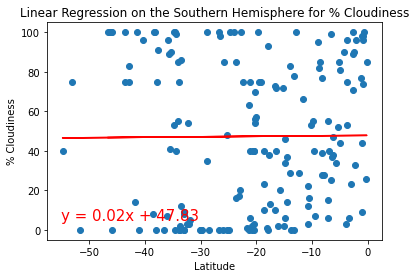

The Rvalue is 0.009


In [56]:
#call the function on cloudiness [southern hemi]

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Cloudiness"],
                        "Linear Regression on the Southern Hemisphere for % Cloudiness",
                        "% Cloudiness",
                        (-55,5))

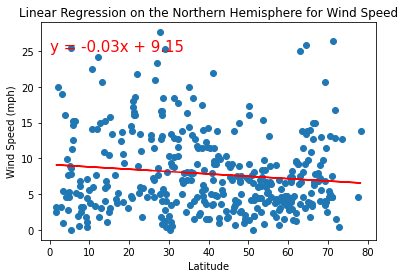

The Rvalue is -0.121


In [53]:
#call the function on wind speed [northern hemi]

plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Wind Speed"],
                        "Linear Regression on the Northern Hemisphere for Wind Speed",
                        "Wind Speed (mph)",
                        (0,25))

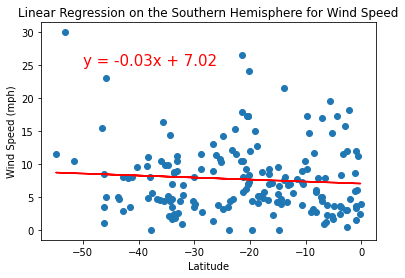

The Rvalue is -0.078


In [57]:
#call the function on wind speed [southern hemi]

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Wind Speed"],
                        "Linear Regression on the Southern Hemisphere for Wind Speed",
                        "Wind Speed (mph)",
                        (-50,25))